In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# Set polars to be verbose.
pl.Config.set_verbose(True)

# Set default figsize.
sns.set_style("whitegrid")

# Data
Data sets for testing inference.

In [2]:
# Set the seed for reproducibility.
np.random.seed(42)

In [3]:
# Generate a random data set.
N = 1000
X_min = 0
X_max = 10

a = 2
b = np.random.normal(0, 1, N)
x = np.linspace(X_min, X_max, N)
y = a * x + b

In [4]:
df = pl.DataFrame({"x": x, "y": y, "a": a, "b": b})

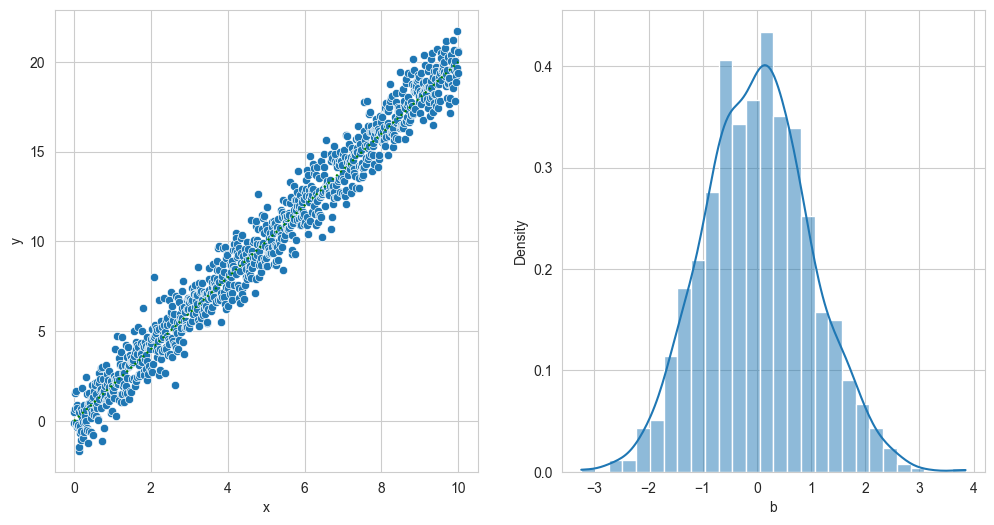

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.scatterplot(ax=ax1, data=df, x="x", y="y")
sns.lineplot(ax=ax1, x=x, y=a*x, color="green", linestyle=":")

sns.histplot(ax=ax2, data=df, x="b", kde=True, stat="density")
None

# Renkon Work
To be moved into the library itself.

In [6]:
%load_ext autoreload
%aimport renkon, renkon.api

In [7]:
import renkon.api as rk

In [8]:
sample = rk.sample.const(k=50)

In [9]:
sample.indices

In [10]:
df.filter(sample.mask)

dataframe filtered


x,y,a,b
f64,f64,i64,f64
0.12012,0.482203,2,0.241962
0.760761,1.608569,2,0.087047
0.900901,1.898879,2,0.097078
1.041041,1.920796,2,-0.161286
1.061061,4.008308,2,1.886186
1.181181,3.505185,2,1.142823
1.221221,3.845237,2,1.402794
1.351351,4.252637,2,1.549934
1.451451,3.684726,2,0.781823


# RANSAC Working Area

In [11]:
import polars as pl
from polars.lazyframe import * 

In [12]:
pl.Config.set_verbose(True)

polars.config.Config

In [36]:
x = np.arange(0.0, 100.0)
y = x
df = pl.DataFrame({"x": x, "y": y})

model = rk.stats.OLSModel("y", ["x"], fit_intercept=True)
fit = model.fit(df)

# Produce some data that should not be explained by this model:
bad_data = pl.from_records([
    (42, 42),  # one good point
    (0.1, 100.0), 
    (5.0, -5.0), 
    (100.0, 0.0)
], schema=("x", "y"))

bad_data.select(fit.errors())

y
f64
-1.4211e-14
99.9
-10.0
-100.0


fit.params

In [37]:
bad_data.select(fit.rsquared(adjust=False))

rsq
f64
-1.829466


In [38]:
bad_data.select(fit.rsquared(adjust=True))

adj_rsq
f64
-7.488397


In [39]:
n = pl.count().alias("n")
k = len(model.x_cols) + int(model.fit_intercept)
dof = (n - k - 1)
bad_data.select(dof) 

n
u32
1


In [30]:
bad_data.select(pl.count())

count
u32
3


In [32]:
model.fit_intercept

True